# 심화 탐색적 데이터 분석 (Advanced EDA)
## 건강검진 데이터를 활용한 콜레스테롤 수치 예측 및 건강지표 연관성 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print("라이브러리 로드 완료")

라이브러리 로드 완료


In [2]:
# 데이터 로드
df = pd.read_csv('./data/health_2023_cleaned_final.csv')

# 기본 정보 출력
print(f"데이터 크기: {df.shape}")
print(f"\n데이터 타입:")
print(df.dtypes)
print(f"\n결측치 현황:")
print(df.isnull().sum().sort_values(ascending=False))

데이터 크기: (332704, 30)

데이터 타입:
기준년도             int64
가입자일련번호          int64
시도코드             int64
성별코드             int64
연령대코드(5세단위)      int64
신장(5cm단위)        int64
체중(5kg단위)        int64
허리둘레           float64
시력(좌)          float64
시력(우)          float64
청력(좌)          float64
청력(우)          float64
수축기혈압          float64
이완기혈압          float64
식전혈당(공복혈당)     float64
총콜레스테롤         float64
트리글리세라이드       float64
HDL콜레스테롤       float64
LDL콜레스테롤       float64
혈색소            float64
요단백            float64
혈청크레아티닌        float64
혈청지오티(AST)     float64
혈청지피티(ALT)     float64
감마지티피          float64
흡연상태           float64
음주여부           float64
구강검진수검여부         int64
치아우식증유무        float64
치석             float64
dtype: object

결측치 현황:
치석             226652
치아우식증유무        226652
요단백              1926
시력(좌)              58
시력(우)              57
청력(좌)              44
청력(우)              44
흡연상태               34
음주여부               22
혈청지오티(AST)          1
감마지티피               0
혈청지피티(ALT)     

## 1. 변수 간 상관관계 분석

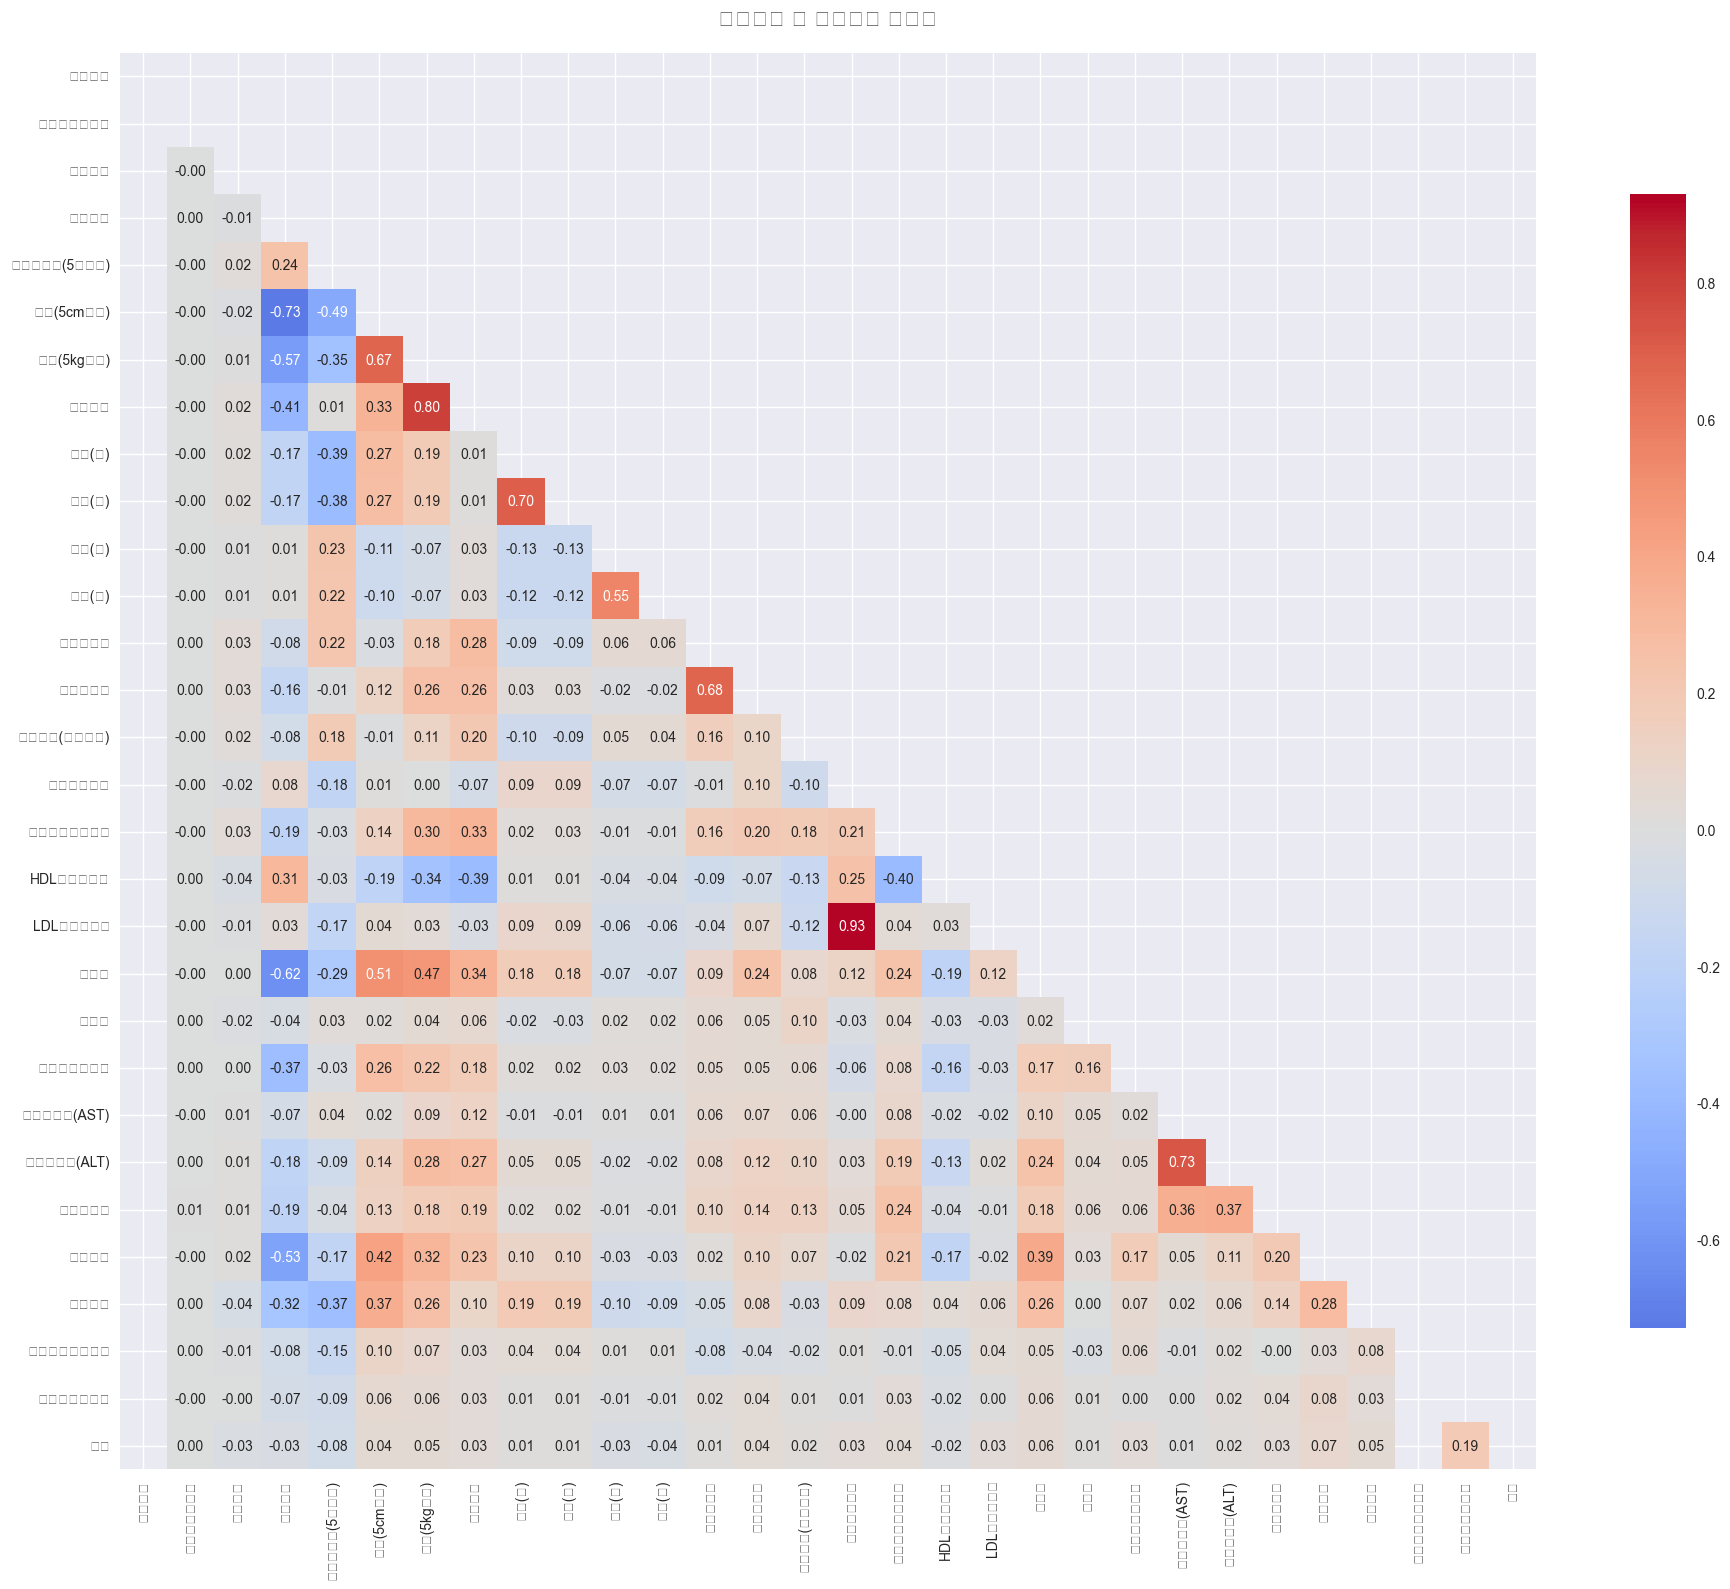

In [3]:
# 수치형 변수만 선택
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 상관계수 계산
correlation_matrix = df[numeric_cols].corr()

# 상관관계 히트맵 생성
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})
plt.title('건강지표 간 상관관계 히트맵', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('./plots/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# 콜레스테롤 관련 변수들과의 상관관계 분석
cholesterol_cols = ['총콜레스테롤', 'HDL콜레스테롤', 'LDL콜레스테롤', '트리글리세라이드']
other_health_cols = ['수축기혈압', '이완기혈압', '식전혈당(공복혈당)', 
                     '체중(5kg단위)', '허리둘레', '혈청지오티(AST)', 
                     '혈청지피티(ALT)', '감마지티피']

# 콜레스테롤과 다른 건강지표 간 상관관계
cholesterol_correlations = pd.DataFrame()
for chol_col in cholesterol_cols:
    correlations = []
    p_values = []
    
    for health_col in other_health_cols:
        # 결측치 제거 후 상관관계 계산
        data_clean = df[[chol_col, health_col]].dropna()
        if len(data_clean) > 0:
            corr, p_val = pearsonr(data_clean[chol_col], data_clean[health_col])
            correlations.append(corr)
            p_values.append(p_val)
        else:
            correlations.append(np.nan)
            p_values.append(np.nan)
    
    cholesterol_correlations[f'{chol_col}_corr'] = correlations
    cholesterol_correlations[f'{chol_col}_pval'] = p_values

cholesterol_correlations.index = other_health_cols
print("콜레스테롤 관련 변수들과 다른 건강지표 간 상관관계:")
print(cholesterol_correlations.round(4))

콜레스테롤 관련 변수들과 다른 건강지표 간 상관관계:
            총콜레스테롤_corr  총콜레스테롤_pval  HDL콜레스테롤_corr  HDL콜레스테롤_pval  \
수축기혈압           -0.0138       0.0000        -0.0898            0.0   
이완기혈압            0.0976       0.0000        -0.0688            0.0   
식전혈당(공복혈당)      -0.0955       0.0000        -0.1348            0.0   
체중(5kg단위)        0.0024       0.1619        -0.3439            0.0   
허리둘레            -0.0653       0.0000        -0.3857            0.0   
혈청지오티(AST)      -0.0040       0.0222        -0.0242            0.0   
혈청지피티(ALT)       0.0295       0.0000        -0.1339            0.0   
감마지티피            0.0516       0.0000        -0.0359            0.0   

            LDL콜레스테롤_corr  LDL콜레스테롤_pval  트리글리세라이드_corr  트리글리세라이드_pval  
수축기혈압             -0.0358            0.0         0.1596            0.0  
이완기혈압              0.0652            0.0         0.2001            0.0  
식전혈당(공복혈당)        -0.1169            0.0         0.1849            0.0  
체중(5kg단위)          0.0349            0.0       

## 2. 통계적 유의성 검정

In [5]:
# 성별에 따른 콜레스테롤 수치 차이 검정 (t-test)
male_cholesterol = df[df['성별코드'] == 1]['총콜레스테롤'].dropna()
female_cholesterol = df[df['성별코드'] == 2]['총콜레스테롤'].dropna()

# 독립표본 t-검정
t_stat, p_value = stats.ttest_ind(male_cholesterol, female_cholesterol)

print(f"성별에 따른 총콜레스테롤 수치 차이 검정")
print(f"남성 평균: {male_cholesterol.mean():.2f} ± {male_cholesterol.std():.2f}")
print(f"여성 평균: {female_cholesterol.mean():.2f} ± {female_cholesterol.std():.2f}")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"유의성: {'유의함' if p_value < 0.05 else '유의하지 않음'} (α=0.05)")

성별에 따른 총콜레스테롤 수치 차이 검정
남성 평균: 193.02 ± 41.74
여성 평균: 199.62 ± 42.11
t-통계량: -45.2178
p-value: 0.0000
유의성: 유의함 (α=0.05)


In [6]:
# 연령대별 콜레스테롤 수치 차이 검정 (ANOVA)
age_groups = df.groupby('연령대코드(5세단위)')['총콜레스테롤'].apply(list)
age_groups_clean = [group for group in age_groups if len(group) > 0]

# 일원분산분석 (One-way ANOVA)
f_stat, p_value_anova = stats.f_oneway(*age_groups_clean)

print(f"\n연령대별 총콜레스테롤 수치 차이 검정 (ANOVA)")
print(f"F-통계량: {f_stat:.4f}")
print(f"p-value: {p_value_anova:.4f}")
print(f"유의성: {'유의함' if p_value_anova < 0.05 else '유의하지 않음'} (α=0.05)")

# 연령대별 평균 비교
age_cholesterol_stats = df.groupby('연령대코드(5세단위)')['총콜레스테롤'].agg(['mean', 'std', 'count'])
print("\n연령대별 총콜레스테롤 수치 통계:")
print(age_cholesterol_stats.round(2))


연령대별 총콜레스테롤 수치 차이 검정 (ANOVA)
F-통계량: 1856.9842
p-value: 0.0000
유의성: 유의함 (α=0.05)

연령대별 총콜레스테롤 수치 통계:
               mean    std  count
연령대코드(5세단위)                      
5            182.44  32.51   6017
6            192.25  33.48  11404
7            200.62  35.68  12252
8            204.97  36.82  10932
9            204.03  37.08  60124
10           205.23  39.21  31140
11           206.88  42.25  35151
12           203.11  44.20  31869
13           194.11  44.10  61110
14           184.94  42.82  28598
15           177.75  41.09  15373
16           173.42  40.46  14226
17           171.29  39.34  12352
18           170.02  40.66   2156


In [7]:
# 흡연 상태와 질병 의심 간의 연관성 검정 (카이제곱 검정)
# 먼저 질병 의심 변수들을 생성
df['고콜레스테롤'] = (df['총콜레스테롤'] >= 240).astype(int)
df['고혈압'] = ((df['수축기혈압'] >= 140) | (df['이완기혈압'] >= 90)).astype(int)
df['고혈당'] = (df['식전혈당(공복혈당)'] >= 126).astype(int)

# 흡연 상태와 고콜레스테롤 간의 연관성
crosstab = pd.crosstab(df['흡연상태'], df['고콜레스테롤'])
chi2, p_val, dof, expected = chi2_contingency(crosstab)

print("흡연 상태와 고콜레스테롤 간의 연관성 검정 (카이제곱 검정)")
print("교차표:")
print(crosstab)
print(f"\nχ² 통계량: {chi2:.4f}")
print(f"p-value: {p_val:.4f}")
print(f"자유도: {dof}")
print(f"유의성: {'유의함' if p_val < 0.05 else '유의하지 않음'} (α=0.05)")

흡연 상태와 고콜레스테롤 간의 연관성 검정 (카이제곱 검정)
교차표:
고콜레스테롤       0      1
흡연상태                 
1.0     179075  31800
2.0      52465   8165
3.0      52168   8997

χ² 통계량: 97.6269
p-value: 0.0000
자유도: 2
유의성: 유의함 (α=0.05)


## 3. 고급 시각화

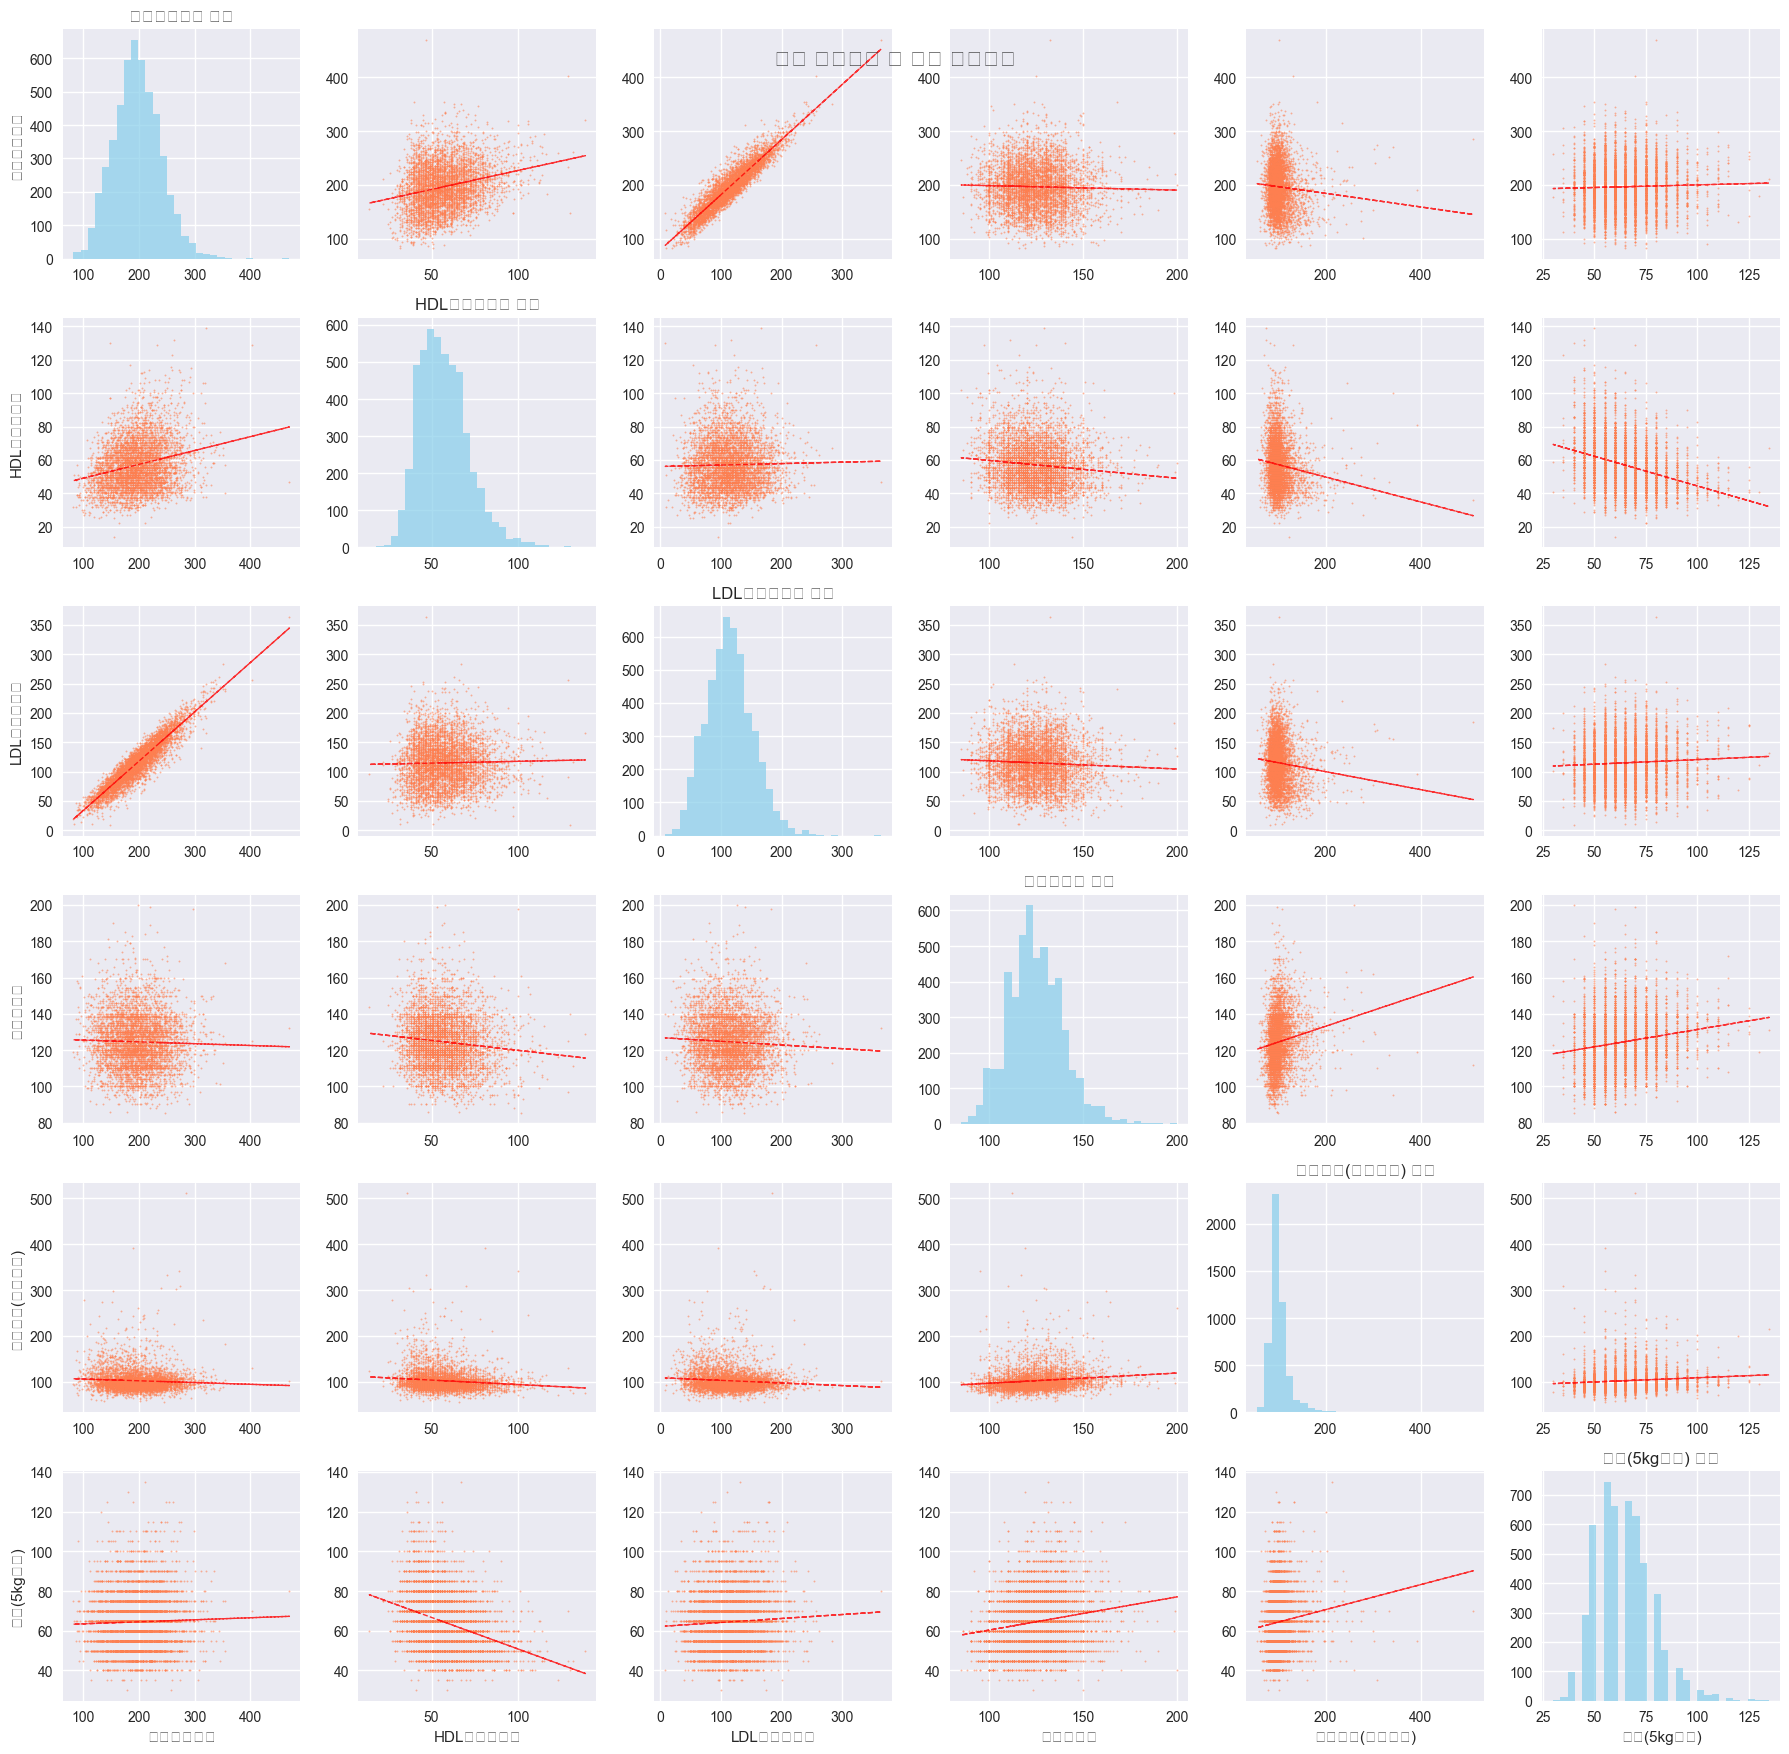

In [8]:
# 주요 건강지표 간 산점도 매트릭스
key_health_vars = ['총콜레스테롤', 'HDL콜레스테롤', 'LDL콜레스테롤', 
                   '수축기혈압', '식전혈당(공복혈당)', '체중(5kg단위)']

# 샘플링 (너무 많은 데이터 포인트를 피하기 위해)
df_sample = df[key_health_vars].dropna().sample(n=min(5000, len(df)), random_state=42)

# 산점도 매트릭스 생성
fig, axes = plt.subplots(len(key_health_vars), len(key_health_vars), 
                        figsize=(18, 18))

for i, var1 in enumerate(key_health_vars):
    for j, var2 in enumerate(key_health_vars):
        if i == j:
            # 대각선: 히스토그램
            axes[i, j].hist(df_sample[var1], bins=30, alpha=0.7, color='skyblue')
            axes[i, j].set_title(f'{var1} 분포')
        else:
            # 비대각선: 산점도
            axes[i, j].scatter(df_sample[var2], df_sample[var1], 
                             alpha=0.5, s=1, color='coral')
            # 회귀선 추가
            z = np.polyfit(df_sample[var2], df_sample[var1], 1)
            p = np.poly1d(z)
            axes[i, j].plot(df_sample[var2], p(df_sample[var2]), 
                          "r--", alpha=0.8, linewidth=1)
        
        axes[i, j].set_xlabel(var2 if i == len(key_health_vars)-1 else '')
        axes[i, j].set_ylabel(var1 if j == 0 else '')

plt.suptitle('주요 건강지표 간 관계 매트릭스', fontsize=16, y=0.95)
plt.tight_layout()
plt.savefig('./plots/scatter_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

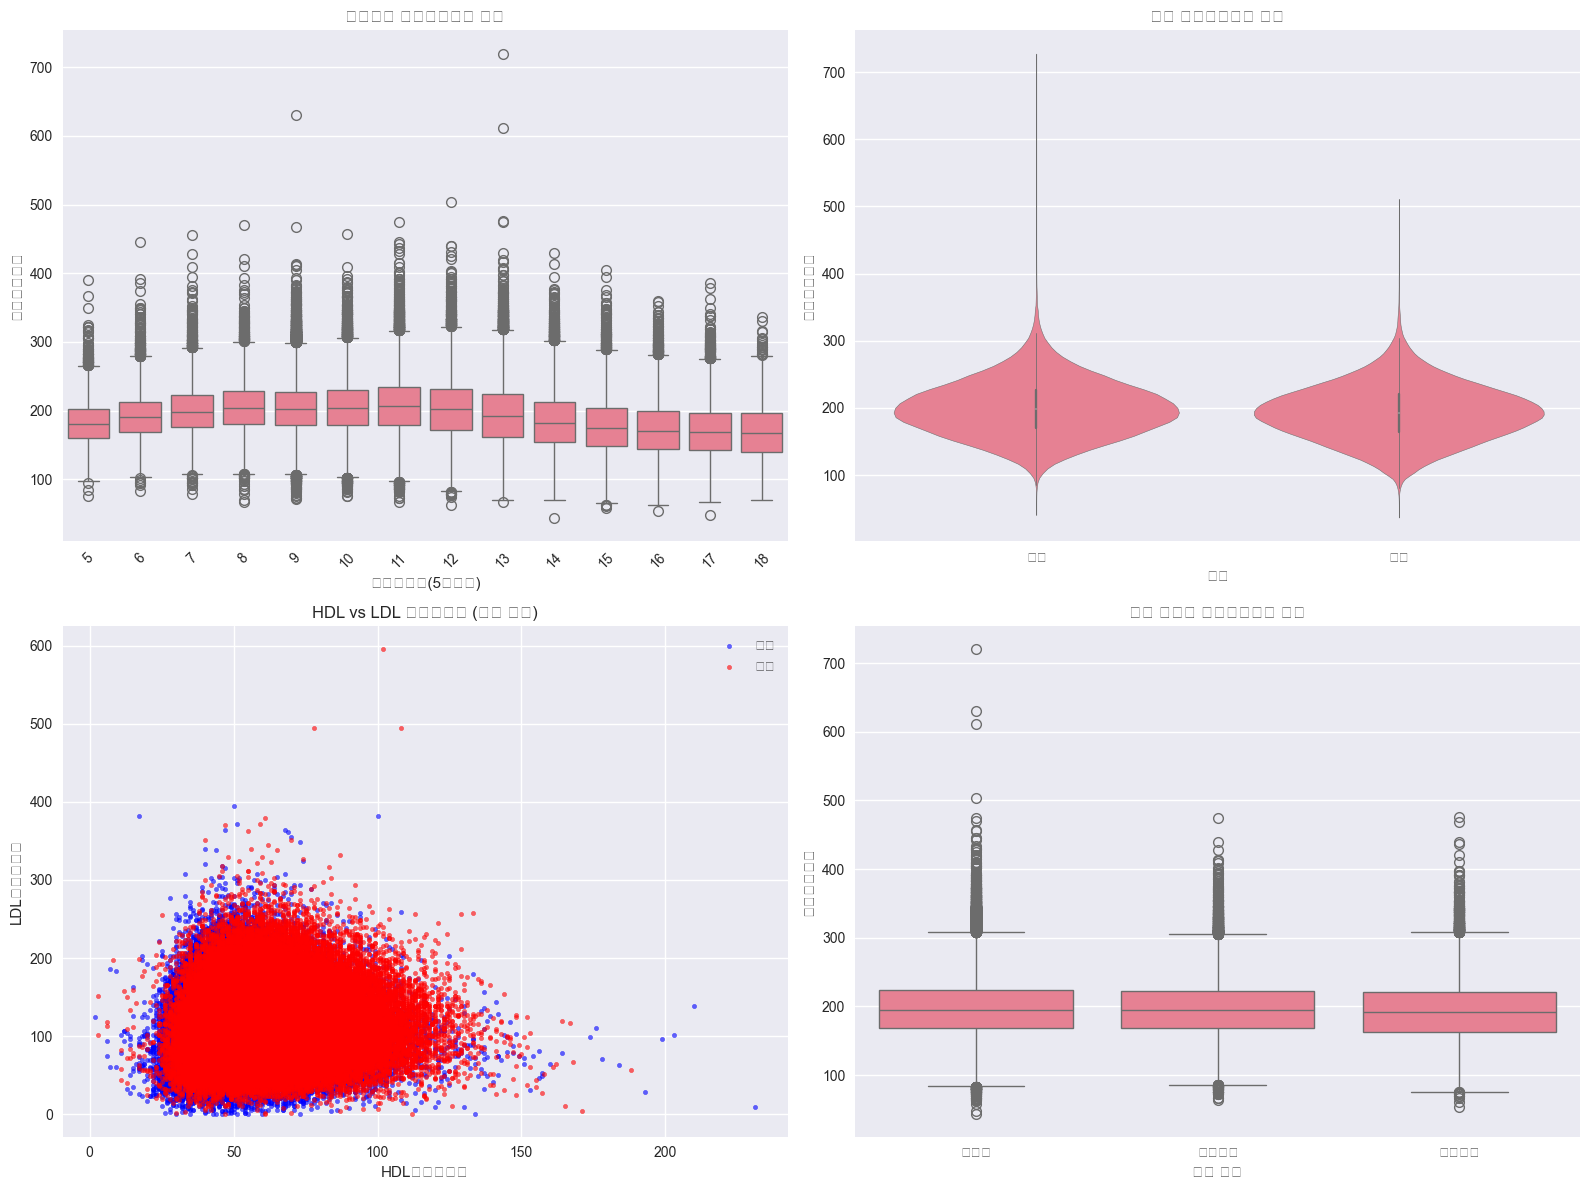

In [9]:
# 연령대별, 성별 콜레스테롤 수치 분석
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 연령대별 콜레스테롤 박스플롯
df_plot = df.dropna(subset=['연령대코드(5세단위)', '총콜레스테롤'])
sns.boxplot(data=df_plot, x='연령대코드(5세단위)', y='총콜레스테롤', ax=axes[0,0])
axes[0,0].set_title('연령대별 총콜레스테롤 분포')
axes[0,0].set_xlabel('연령대코드(5세단위)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. 성별 콜레스테롤 바이올린 플롯
df_plot_gender = df.dropna(subset=['성별코드', '총콜레스테롤'])
df_plot_gender['성별'] = df_plot_gender['성별코드'].map({1: '남성', 2: '여성'})
sns.violinplot(data=df_plot_gender, x='성별', y='총콜레스테롤', ax=axes[0,1])
axes[0,1].set_title('성별 총콜레스테롤 분포')

# 3. HDL vs LDL 산점도 (성별 구분)
df_chol = df.dropna(subset=['HDL콜레스테롤', 'LDL콜레스테롤', '성별코드'])
colors = {1: 'blue', 2: 'red'}
labels = {1: '남성', 2: '여성'}
for gender in [1, 2]:
    gender_data = df_chol[df_chol['성별코드'] == gender]
    axes[1,0].scatter(gender_data['HDL콜레스테롤'], gender_data['LDL콜레스테롤'], 
                     alpha=0.6, c=colors[gender], label=labels[gender], s=10)
axes[1,0].set_xlabel('HDL콜레스테롤')
axes[1,0].set_ylabel('LDL콜레스테롤')
axes[1,0].set_title('HDL vs LDL 콜레스테롤 (성별 구분)')
axes[1,0].legend()

# 4. 흡연 상태별 콜레스테롤 분포
df_smoking = df.dropna(subset=['흡연상태', '총콜레스테롤'])
smoking_labels = {1: '비흡연', 2: '과거흡연', 3: '현재흡연'}
df_smoking['흡연상태_라벨'] = df_smoking['흡연상태'].map(smoking_labels)
sns.boxplot(data=df_smoking, x='흡연상태_라벨', y='총콜레스테롤', ax=axes[1,1])
axes[1,1].set_title('흡연 상태별 총콜레스테롤 분포')
axes[1,1].set_xlabel('흡연 상태')

plt.tight_layout()
plt.savefig('./plots/demographic_cholesterol_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. 구강 건강과 전신 건강 연관성 분석

In [10]:
# 구강 건강 지표와 전신 건강 지표 간 연관성 분석
oral_health_vars = ['치석', '치아우식증유무']
systemic_health_vars = ['총콜레스테롤', 'HDL콜레스테롤', 'LDL콜레스테롤', 
                       '수축기혈압', '이완기혈압', '식전혈당(공복혈당)']

# 구강 건강과 전신 건강 간 상관관계 분석
oral_systemic_corr = pd.DataFrame()

for oral_var in oral_health_vars:
    correlations = []
    p_values = []
    
    for sys_var in systemic_health_vars:
        # 결측치 제거
        data_clean = df[[oral_var, sys_var]].dropna()
        
        if len(data_clean) > 10:  # 충분한 데이터가 있는 경우만
            # 스피어만 상관계수 사용 (서열 데이터 특성 고려)
            corr, p_val = spearmanr(data_clean[oral_var], data_clean[sys_var])
            correlations.append(corr)
            p_values.append(p_val)
        else:
            correlations.append(np.nan)
            p_values.append(np.nan)
    
    oral_systemic_corr[f'{oral_var}_corr'] = correlations
    oral_systemic_corr[f'{oral_var}_pval'] = p_values

oral_systemic_corr.index = systemic_health_vars
print("구강 건강과 전신 건강 간 상관관계 분석:")
print(oral_systemic_corr.round(4))

# 유의한 상관관계 찾기
print("\n유의한 상관관계 (p < 0.05):")
for oral_var in oral_health_vars:
    significant_corr = oral_systemic_corr[oral_systemic_corr[f'{oral_var}_pval'] < 0.05]
    if not significant_corr.empty:
        print(f"\n{oral_var}와 유의한 상관관계:")
        for idx in significant_corr.index:
            corr_val = significant_corr.loc[idx, f'{oral_var}_corr']
            p_val = significant_corr.loc[idx, f'{oral_var}_pval']
            print(f"  - {idx}: r={corr_val:.4f}, p={p_val:.4f}")

구강 건강과 전신 건강 간 상관관계 분석:
            치석_corr  치석_pval  치아우식증유무_corr  치아우식증유무_pval
총콜레스테롤       0.0370   0.0000        0.0052        0.0910
HDL콜레스테롤    -0.0215   0.0000       -0.0277        0.0000
LDL콜레스테롤     0.0334   0.0000        0.0031        0.3171
수축기혈압        0.0059   0.0559        0.0233        0.0000
이완기혈압        0.0314   0.0000        0.0363        0.0000
식전혈당(공복혈당)   0.0154   0.0000        0.0042        0.1686

유의한 상관관계 (p < 0.05):

치석와 유의한 상관관계:
  - 총콜레스테롤: r=0.0370, p=0.0000
  - HDL콜레스테롤: r=-0.0215, p=0.0000
  - LDL콜레스테롤: r=0.0334, p=0.0000
  - 이완기혈압: r=0.0314, p=0.0000
  - 식전혈당(공복혈당): r=0.0154, p=0.0000

치아우식증유무와 유의한 상관관계:
  - HDL콜레스테롤: r=-0.0277, p=0.0000
  - 수축기혈압: r=0.0233, p=0.0000
  - 이완기혈압: r=0.0363, p=0.0000


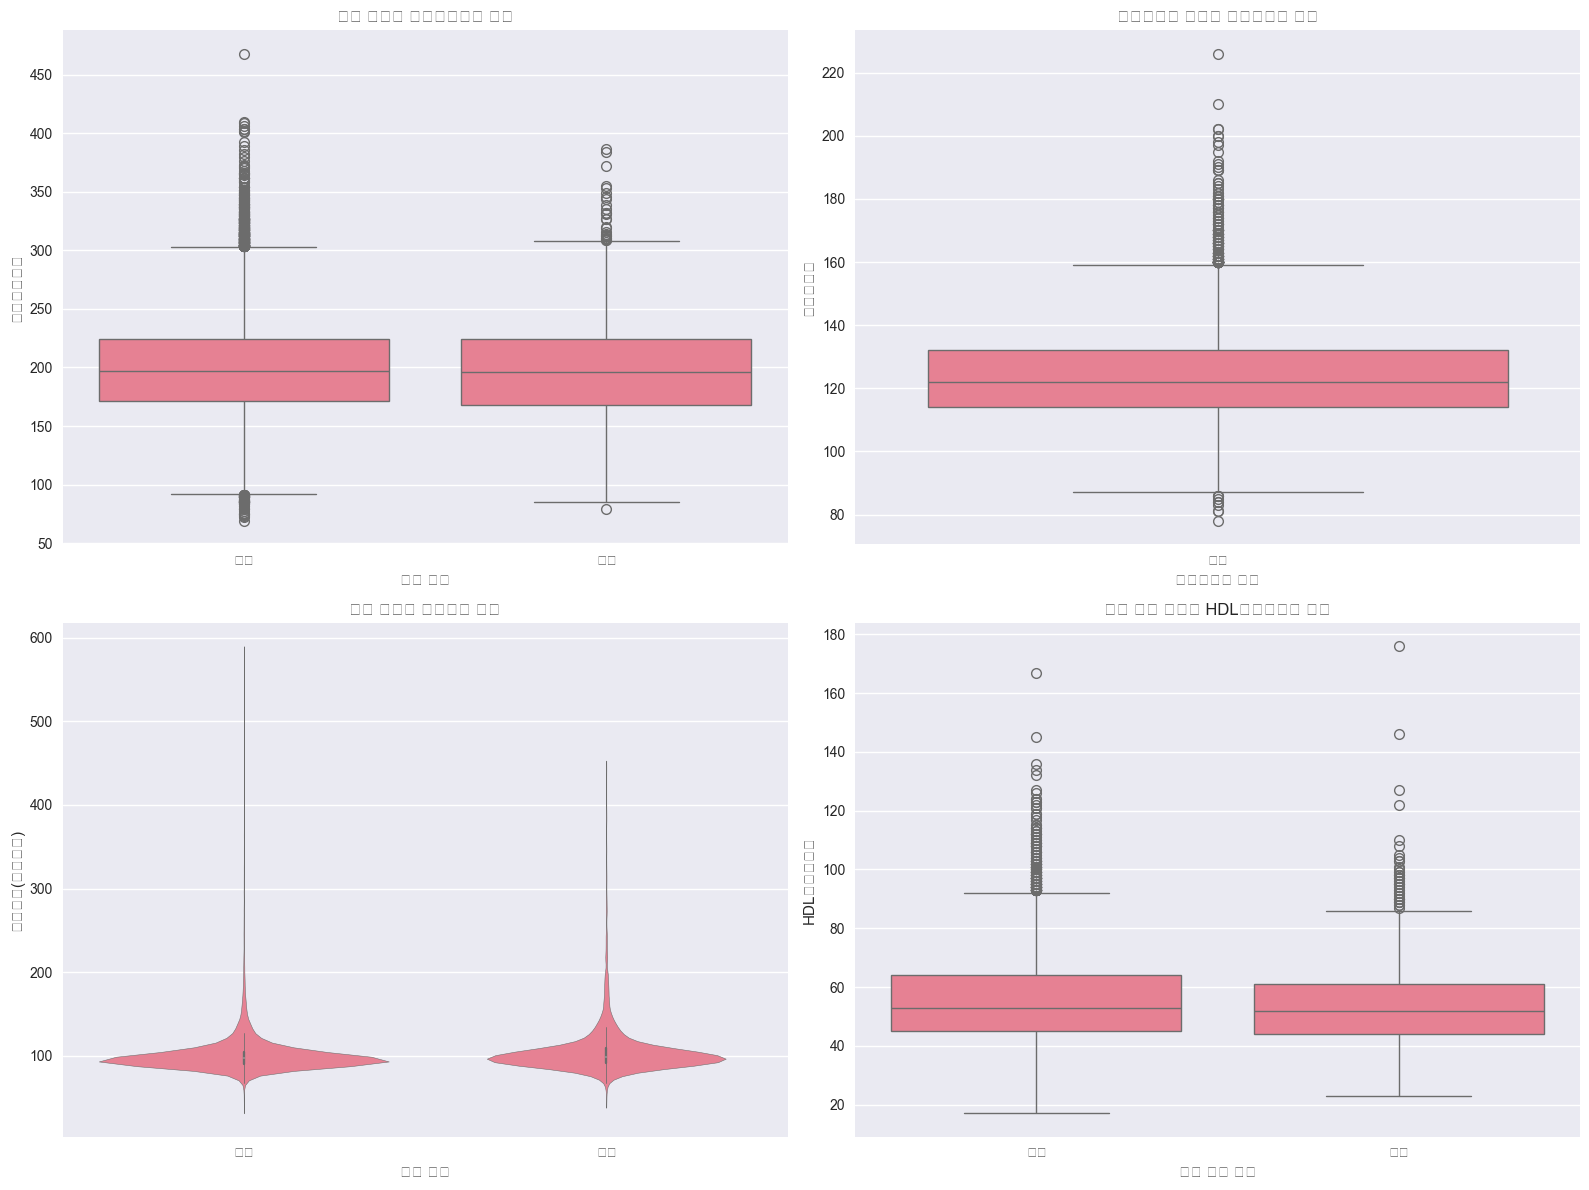

In [11]:
# 구강 건강 상태별 전신 건강 지표 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 치석 상태별 콜레스테롤 분포
df_tartar = df.dropna(subset=['치석', '총콜레스테롤'])
tartar_labels = {1: '없음', 2: '있음'}
df_tartar['치석_라벨'] = df_tartar['치석'].map(tartar_labels)
sns.boxplot(data=df_tartar, x='치석_라벨', y='총콜레스테롤', ax=axes[0,0])
axes[0,0].set_title('치석 상태별 총콜레스테롤 분포')
axes[0,0].set_xlabel('치석 상태')

# 치아우식증 상태별 혈압 분포
df_caries = df.dropna(subset=['치아우식증유무', '수축기혈압'])
caries_labels = {1: '없음', 2: '있음'}
df_caries['우식증_라벨'] = df_caries['치아우식증유무'].map(caries_labels)
sns.boxplot(data=df_caries, x='우식증_라벨', y='수축기혈압', ax=axes[0,1])
axes[0,1].set_title('치아우식증 상태별 수축기혈압 분포')
axes[0,1].set_xlabel('치아우식증 상태')

# 치석 상태별 혈당 분포
df_tartar_glucose = df.dropna(subset=['치석', '식전혈당(공복혈당)'])
df_tartar_glucose['치석_라벨'] = df_tartar_glucose['치석'].map(tartar_labels)
sns.violinplot(data=df_tartar_glucose, x='치석_라벨', y='식전혈당(공복혈당)', ax=axes[1,0])
axes[1,0].set_title('치석 상태별 공복혈당 분포')
axes[1,0].set_xlabel('치석 상태')

# 구강 건강 종합 점수와 대사 건강 지표
# 구강 건강 종합 점수 생성 (치석 + 치아우식증)
df_oral_total = df.dropna(subset=['치석', '치아우식증유무', 'HDL콜레스테롤'])
df_oral_total['구강건강점수'] = (df_oral_total['치석'] - 1) + (df_oral_total['치아우식증유무'] - 1)
oral_score_labels = {0: '우수', 1: '보통', 2: '나쁨'}
df_oral_total['구강건강_라벨'] = df_oral_total['구강건강점수'].map(oral_score_labels)
sns.boxplot(data=df_oral_total, x='구강건강_라벨', y='HDL콜레스테롤', ax=axes[1,1])
axes[1,1].set_title('구강 건강 상태별 HDL콜레스테롤 분포')
axes[1,1].set_xlabel('구강 건강 상태')

plt.tight_layout()
plt.savefig('./plots/oral_health_systemic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. 주요 인사이트 요약

In [12]:
# 주요 통계 요약
print("=== 건강검진 데이터 심화 분석 결과 요약 ===")
print("\n1. 기본 통계:")
print(f"   - 총 데이터 수: {len(df):,}명")
print(f"   - 평균 총콜레스테롤: {df['총콜레스테롤'].mean():.1f} mg/dL")
print(f"   - 고콜레스테롤(≥240) 비율: {(df['총콜레스테롤'] >= 240).mean()*100:.1f}%")

print("\n2. 성별 차이:")
gender_stats = df.groupby('성별코드')['총콜레스테롤'].agg(['mean', 'std'])
print(f"   - 남성: {gender_stats.loc[1, 'mean']:.1f} ± {gender_stats.loc[1, 'std']:.1f} mg/dL")
print(f"   - 여성: {gender_stats.loc[2, 'mean']:.1f} ± {gender_stats.loc[2, 'std']:.1f} mg/dL")

print("\n3. 연령대별 특성:")
age_chol_mean = df.groupby('연령대코드(5세단위)')['총콜레스테롤'].mean()
max_age_group = age_chol_mean.idxmax()
min_age_group = age_chol_mean.idxmin()
print(f"   - 최고 평균 콜레스테롤 연령대: {max_age_group}세 ({age_chol_mean[max_age_group]:.1f} mg/dL)")
print(f"   - 최저 평균 콜레스테롤 연령대: {min_age_group}세 ({age_chol_mean[min_age_group]:.1f} mg/dL)")

print("\n4. 구강 건강과 전신 건강:")
if '치석' in df.columns and '총콜레스테롤' in df.columns:
    tartar_chol = df.groupby('치석')['총콜레스테롤'].mean()
    if len(tartar_chol) >= 2:
        print(f"   - 치석 없음: 평균 콜레스테롤 {tartar_chol[1]:.1f} mg/dL")
        print(f"   - 치석 있음: 평균 콜레스테롤 {tartar_chol[2]:.1f} mg/dL")
        print(f"   - 차이: {tartar_chol[2] - tartar_chol[1]:.1f} mg/dL")

print("\n5. 생활습관과 건강지표:")
if '흡연상태' in df.columns:
    smoking_chol = df.groupby('흡연상태')['총콜레스테롤'].mean()
    print(f"   흡연 상태별 평균 콜레스테롤:")
    for status, chol in smoking_chol.items():
        status_label = {1: '비흡연', 2: '과거흡연', 3: '현재흡연'}.get(status, f'상태{status}')
        print(f"     - {status_label}: {chol:.1f} mg/dL")

print("\n=== 분석 완료 ===")

=== 건강검진 데이터 심화 분석 결과 요약 ===

1. 기본 통계:
   - 총 데이터 수: 332,704명
   - 평균 총콜레스테롤: 196.0 mg/dL
   - 고콜레스테롤(≥240) 비율: 14.7%

2. 성별 차이:
   - 남성: 193.0 ± 41.7 mg/dL
   - 여성: 199.6 ± 42.1 mg/dL

3. 연령대별 특성:
   - 최고 평균 콜레스테롤 연령대: 11세 (206.9 mg/dL)
   - 최저 평균 콜레스테롤 연령대: 18세 (170.0 mg/dL)

4. 구강 건강과 전신 건강:
   - 치석 없음: 평균 콜레스테롤 198.4 mg/dL
   - 치석 있음: 평균 콜레스테롤 196.6 mg/dL
   - 차이: -1.8 mg/dL

5. 생활습관과 건강지표:
   흡연 상태별 평균 콜레스테롤:
     - 비흡연: 196.9 mg/dL
     - 과거흡연: 192.7 mg/dL
     - 현재흡연: 196.3 mg/dL

=== 분석 완료 ===
